In [1]:
# data load 등을 위한 chdir
import os
os.chdir("../introduction_to_ml_with_python-master/")

# graph 출력을 위한 기본설정
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 불필요한 경고 문구 출력 방지를 위한 설정
import warnings
warnings.filterwarnings(action='ignore')

# basic packages import
import sys
import sklearn
import numpy as np
import matplotlib.pyplot as plt

### MNIST

In [4]:
# openml.org repository로부터 MNIST 데이터셋 로드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

# '''
# 흑백의 28*28픽셀 이미지로, 수기로 작성된 숫자 이미지임.
# '''

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
# 로드한 데이터 셋 저장
X, y = mnist['data'], mnist['target']

print(X.shape, y.shape)

(70000, 784) (70000,)


(-0.5, 27.5, 27.5, -0.5)

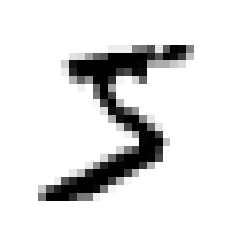

In [11]:
# sample data를 이미지로 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

# 0번째 데이터 추출
some_digit = X[0]

# flat한 데이터를 reshape하여 이미지 형태로 변환
some_digit_image = some_digit.reshape(28, 28)

# colormap을 흑백으로 사용하기 위해 cmap 매개변수에 'binary' 전달
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')

In [19]:
# 이미지에 해당하는 label과 데이터 타입 확인
print(y[0], type(y[0]))

# 데이터 타입 변환
y = y.astype(np.uint8)

5 <class 'str'>


In [22]:
# 추후 이미지 출력을 간편하기 위해 함수 정의
def plot_digit(data) :
    image = data.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='nearest')
    plt.axis('off')
    pass # plot_digit

# 여러 이미지 출력을 위한 추가 함수 정의
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    pass # plot_digits

# '''
# interpolation 매개변수에 준 nearest는 중간의 값을 보간하여 안티앨리어싱 하는 기법임.
# '''

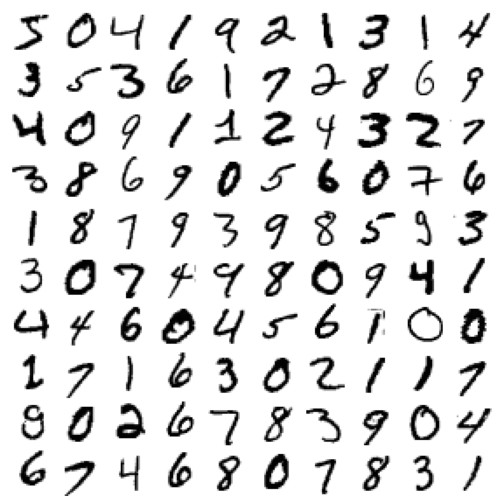

In [23]:
# 이미지 100개 출력하여 확인
plt.figure(figsize=(9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [24]:
# train과 test 데이터 셋 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 이진분류기

In [25]:
# 10개의 다진 분류문제이기 때문에 이진분류로 label을 변경
# 5인 label 양성(True, 1)이 되고, 5가 아닌 label은 음성(False, 0)이 됨
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [26]:
# 확률적 경사하강법 알고리즘을 사용해 학습
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

# '''
# SGDClassifer는 경사하강법을 사용하며 여러 분류기를 만들 수 있음.
# 기본적으로는 SVM을 경사하강법으로 풂.
# max_iter는 최대 반복 횟수를 지정하는 매개변수임.
# tol은 모델이 학습 중에 손실함수 값 변화가 tol값을 넘지 못하면 조기종료하는 매개변수임.
# '''

SGDClassifier(random_state=42)

In [27]:
# 0번째 데이터에 대한 예측
sgd_clf.predict([some_digit])

# '''
# predict 매서드에 2차원 배열로 전달해야 하기 떄문에, 대괄호로 감쌌음.
# '''

array([ True])

In [28]:
# 모델의 성능 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring='accuracy')

# '''
# 실질적으로 양성 데이터는 전체 데이터의 10%밖에 되지 않기에, 결과 해석에 유의해야 함.
# '''

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [30]:
# 데이터의 비율을 동일하도록 계층적 샘플링 수행
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 계층적으로 3겹을 가진 모델 생성
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [31]:
# for문을 통한 skfold 수행
for train_index, test_index in skfolds.split(X_train, y_train_5) :
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    pass # skfold loop

0.95035
0.96035
0.9604


In [32]:
# cross_val_score의 cv매개변수를 이용해 skfold 수행
cross_val_score(sgd_clf, X_train, y_train_5, cv=skfolds)

array([0.95035, 0.96035, 0.9604 ])

In [34]:
# 모든 것을 음성(False, 0)으로 판단하는 분류기 생성
from sklearn.base import BaseEstimator

# GridSearch나 cross_val_score를 내기 위해 BaseEstimator를 상속
class Never5Classifier(BaseEstimator) :
    def fit(self, X, y=None) :
        pass # fit
    def predict(self, X) :
        return np.zeros((len(X), 1), dtype=bool)
    pass # Never5Classifier class

# 분류기 인스턴스 생성
never_5_clf = Never5Classifier()

# 모든걸 음성으로 예측하는 분류기의 성능 확인
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

# '''
# 모든 accuracy score가 0.9이상 나옴.
# '''

array([0.91125, 0.90855, 0.90915])

In [37]:
# 모델이 예측한 결과 확인
from sklearn.model_selection import cross_val_predict

# cross_val_predict는 예측한 결과를 array로 리턴
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [38]:
# 오차행렬을 통해 모델의 성능 확인
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# '''
# 오차행렬의 첫번째 행은 실제 데이터가 음성인 것을 의미함.
# 오차행렬의 두번째 행은 실제 데이터가 양성인 것을 의미함.
# 오차행렬의 첫번째 열은 예측한 결과가 음성인 것을 의미함.
# 오차행렬의 두번째 열은 예측한 결과가 양성인 것을 의미함.
# '''

array([[53892,   687],
       [ 1891,  3530]])

In [39]:
# 완벽한 답안지로 오차행렬 확인
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

# '''
# [[TN FP]
#  [FN TP]]
# 오차행렬의 결과는 위와 같은 모양을 의미함.
# 정밀도는 예측이 P인 것 중 T인 것으로 TP / TP + FP임.
# 재현율은 실제가 P인 것 중 T인 것으로 TP / TP + FN임.
# '''

array([[54579,     0],
       [    0,  5421]])

In [40]:
# 정밀도와 재현율 확인
from sklearn.metrics import precision_score, recall_score

print('정밀도 :', precision_score(y_train_5, y_train_pred))
print('재현율 :', recall_score(y_train_5, y_train_pred))

정밀도 : 0.8370879772350012
재현율 : 0.6511713705958311


In [42]:
# 정밀도와 재현율의 조화평균인 F1 Score 확인
from sklearn.metrics import f1_score

print('F1 Score :', f1_score(y_train_5, y_train_pred))

F1 Score : 0.7325171197343846


In [44]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
print(sgd_clf.predict([some_digit]))

# '''
# sgd_clf가 예측을 하는 근거는 decision_function에 의한 값임.
# 이 값과 임계값(threshold)을 비교하여 예측 결과를 리턴함.
# 임계값의 디폴트는 0으로, 0보다 크면 양성 클래스로, 0보다 작으면 음성 클래스로 분류함.
# 임계값과 값이 떨어져 있을수록 예측을 확신한다는 의미임.
# '''

[2164.22030239]
[ True]


In [45]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')
y_scores

# '''
# method 매개변수의 디폴트 값은 predict_function으로 예측 값이 출력됨.
# decision_function을 전달하면, 예측한 정도가 score로 출력됨.
# '''

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [48]:
# precision과 recall의 관계를 보기 위해 curve를 그릴 데이터를 저장
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

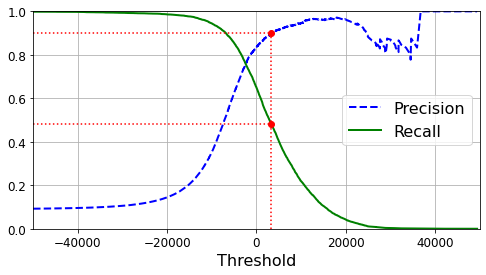

In [49]:
# threshold의 값의 변화에 따른 두 지표의 값 변화를 표현
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # thresholds를 X축으로 지정
    # precisions과 recalls는 관측치보다 1개가 더 많기 떄문에 슬라이싱
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

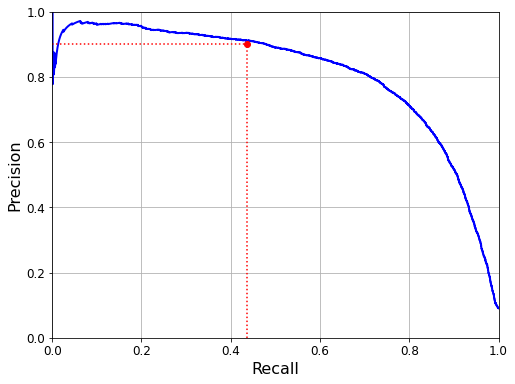

In [50]:
# precision과 recall의 관계를 보기 위해 recall을 X축에 배치
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [52]:
# 위 그래프의 면적을 구한 score
from sklearn.metrics import average_precision_score

average_precision_score(y_train_5, y_scores)

# '''
# 값이 높을 수록 좋은 모델임.
# '''

0.810041762752646

In [54]:
# 원하는 precision의 값이 있을 경우, 해당 값을 도출할 수 있는 threshold를 탐색
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print('threshold :', threshold_90_precision)

# 해당 threshold일 때 지표 확인
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('precision :', precision_score(y_train_5, y_train_pred_90))
print('recall :', recall_score(y_train_5, y_train_pred_90))

threshold : 3370.0194991439557
precision : 0.9000345901072293
recall : 0.4799852425751706


### ROC 곡선

In [55]:
# ROOC 곡선 확인 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# '''
# 거짓 양성비율(FPR)은 실제로 음성인 것 중 잘못 예측한 것으로 FP / FP + TN이며, 오분률이라고도 함.
# tpr은 재현율과 동일하게 TP / FN + TP임.
# '''

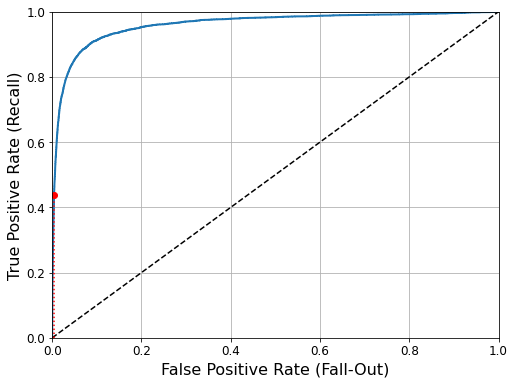

In [56]:
# ROC 곡선 시각화
def plot_roc_curve(fpr, tpr, label=None):
    # X축에 fpr, Y축에 tpr을 놓음.
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [57]:
# 곡선 아래 면적을 계산한 score확인
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [60]:
# sgd 모델과 비교하기 위해 randomforest 모델 사용
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

# '''
# linear regression 등의 모델은 방정식으로 표현할 수 있어 decision_function이 있음.
# tree 기반 모델은 방정식으로 표현할 수 없어서, decision_function이 없음.
# 대신, predict_proba 메서드를 가지고 있어, 예측의 확률값을 리턴받을 수 있음.
# '''

In [61]:
# 양성으로 분류한 값만 저장
y_scores_forest = y_probas_forest[:, 1]

# roc_curve를 그리기 위해 값 저장
fpr_forest, tpr_forest, thresholds_fores = roc_curve(y_train_5, y_scores_forest)

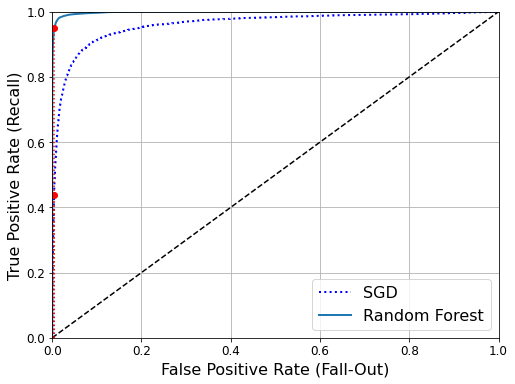

In [62]:
# randomforest 모델의 roc 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [63]:
# roc_auc_score 확인
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 다중 분류

In [64]:
# SVC 모델을 사용해 OvO방식으로 다중분류
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [66]:
# decision_function으로 각 클래스별 예측정도를 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [68]:
# decision_fuction의 값 중 가장 큰 값이 무엇인지 확인
print(np.argmax(some_digit_scores))

# svm_clf의 label 클래스 확인
print(svm_clf.classes_)

# svm_clf의 label 중, 예측한 값을 출력
print(svm_clf.classes_[np.argmax(some_digit_scores)])

# '''
# decision_function은 확률값이 아님.
# 클래스를 예측한 정도가 가장 큰 클래스를 예측값으로 출력함.
# MNIST 데이터셋은 클래스의 인덱스와 label의 값이 동일하므로, 인덱스 5는 label 5와 동일함.
# '''

5
[0 1 2 3 4 5 6 7 8 9]
5


In [70]:
# OneVsRestClassifier모델로 OvR방식으로 다중분류
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

# '''
# OneVsOneClassifier 클래스도 있음.
# '''

array([5], dtype=uint8)

In [71]:
# ovr_clf 모델이 만든 분류기의 갯수 확인
len(ovr_clf.estimators_)

10

In [72]:
# sgd_clf로 Multinomial방식을 사용한 다중분류
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [73]:
# sgd_clf의 decision_function 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [74]:
# 교차검증을 통한 모델의 성능 확인
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [75]:
# sklearn에 새로 추가된 cross_validate 메서드 사용
from sklearn.model_selection import cross_validate
cross_validate(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

{'fit_time': array([116.47462368,  95.64558029,  93.43100381]),
 'score_time': array([0.05739331, 0.05901575, 0.06794167]),
 'test_score': array([0.87365, 0.85835, 0.8689 ])}

In [76]:
# StandardScaler로 스케일링 수행
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# 교차검증 수행
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

# '''
# sgd_clf는 경사하강법을 사용함. 값이 큰 특성에 영향을 받지 않도록 scale을 수행해야 함.
# 경사하강법을 사용하는 모델은 scale에 민감하기 때문에 수행함.
# 거리를 기반으로 하는 모델들도, scale을 수행해줘야 함.
# 규제가 있는 선형 모델(리지, 라쏘 등)들도, scale을 수행해줘야 함.
# SVM도, scale을 수행해줘야 함.
# tree 모델은 거리에 영향을 받지 않음.
# '''

array([0.8983, 0.891 , 0.9018])

In [78]:
# scale한 데이터로 예측한 오차행렬 확인
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [79]:
# 오차행렬을 위한 함수 정의
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

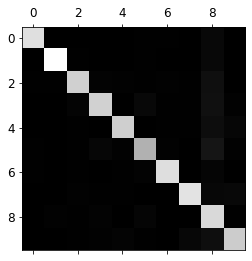

In [80]:
# 오차행렬 시각화
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

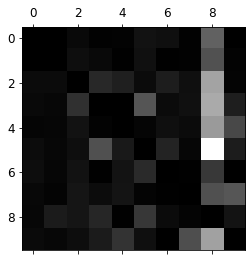

In [81]:
# 각 행을 따라서 더한 값으로 나눔으로서 행별 비율을 저장
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# '''
# 8로 착각하는 경우가 많은 것을 확인할 수 있음.
# 3과 5를 서로 착각하는 경우가 많은 것을 확인할 수 있음.
# '''

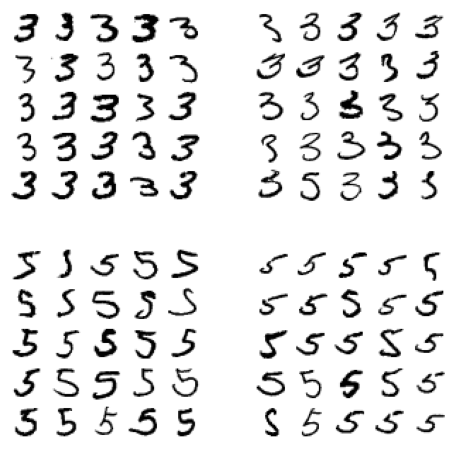

In [82]:
# 3과 5의 이미지를 출력해서 확인
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# '''
# 1, 4 사분면은 각 이미지에 따라 잘 분류한 것임.
# 2, 3 사분면은 각 이미지를 잘못 분류한 것임.
# '''

### 다중 레이블 분류

In [83]:
# 다중 레이블 분류를 위한 KNN 모델 사용
from sklearn.neighbors import KNeighborsClassifier

# 7보다 큰 값인지, 홀수인지를 판단하는 다중 레이블 생성
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [84]:
# some_digit으로 예측
knn_clf.predict([some_digit])

array([[False,  True]])

In [85]:
# 다중 레이블에 대한 f1 score 확인
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

# '''
# average는 각 레이블에 대한 score를 어떻게 평균낼지를 결정하는 매개변수임.
# 기본값은 'macro'로, 각 레이블에 대해서 f1 score를 내고, 두 값에 대해서 평균을 냄.
# 'weighted'는 각 레이블에 대해서 f1 score를 내고, 두 값에 대해서 샘플 수 별로 가중평균을 냄.
# 'micro'는 모든 레이블의 TN, FP, FN, TP를 더한 다음 f1 score를 냄.
# '''

0.976410265560605

### 다중 출력 분류

In [87]:
# noise를 발생시켜, train셋 생성
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# noise가 낀 train셋으로부터 원본의 꺠끗한 train 이미지를 찾도록 저장
y_train_mod = X_train
y_test_mod = X_test

# 타겟 값이 1개의 숫자가 아니라, 배열의 형태가 됨.
y_test_mod.shape

(10000, 784)

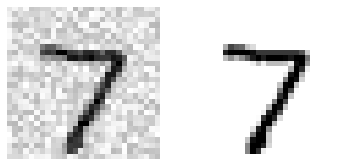

In [88]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

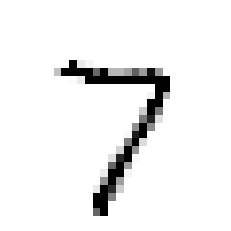

In [89]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

### 추가내용

In [90]:
# 더미(랜덤) 분류기 생성
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy='stratified')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3,
                                method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

# '''
# strategy 매개변수는 더미 분류기가 어떻게 예측을 수행할 지를 결정함.
# 'stratifed'는 타겟 값의 비율과 동일한 확률로 랜덤하게 예측함.
# 'most_frequent'는 타겟 값의 비율 중 가장 높은 것으로, 모든 것에 대해 예측함.
# 'prior'는 most_frequent와 비슷하나 가장 높은 것으로부터 확률적으로 예측함.
# '''

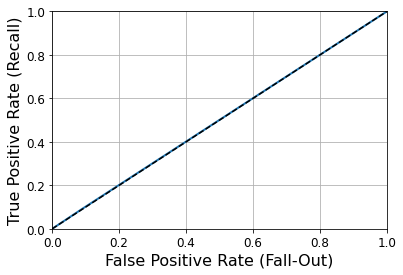

In [91]:
# roc 곡선 시각화
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

# '''
# 'stratified' 방식으로, 모든 값에 대해 동일한 확률로 예측하여, 직선이 출력됨.
# '''

### KNN 분류기

In [95]:
# KNeighborsClassifier를 사용한 분류
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [96]:
# test 세트 예측
y_knn_pred = knn_clf.predict(X_test)

In [97]:
# accuracy score 확인
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

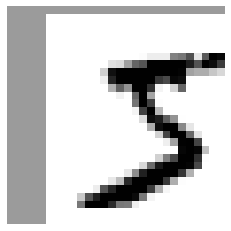

In [99]:
# 이미지scipy.ndimage.interpolationport
from scipy.ndimage.interpolation import shift

# 이미지의 위치를 변경시키고 다시 flat하게 만드는 함수 생성
def shift_digit(digit_array, dx, dy, new=0) :
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

# 위치를 변경한 이미지 출력
plot_digit(shift_digit(some_digit, 5, 1, new=100))

# '''
# 위와 같이 위치를 변경한 이미지도 학습을 하게 되면, 숫자의 위치에 덜 민감하게 만들 수 있음.
# '''